In [1]:
# ──────────────────────────────────────────────────────────────
#  CERES – phenotype classification (PCD / SCA / Controls)
#  -------------------------------------------------------------
#  • 5-fold Stratified CV (shuffle=True, random_state=42)
#  • Best single feature  vs.  Random-Forest (500 trees)
#  • Outputs:
#        – 3 high-res ROC PNGs   
#        – Excel workbook        
# ──────────────────────────────────────────────────────────────
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics        import roc_curve, roc_auc_score
from sklearn.ensemble       import RandomForestClassifier
import seaborn as sns

# ── 1. READ ───────────────────────────────────────────────────
df = pd.read_csv('../data/normal_yo_SCA/CERES_Agusti.csv', sep=',')

target     = 'Phenotype'
num_cols   = df.select_dtypes(include=[np.number]).columns.tolist()
excel_path = 'CERES_ROC_results.xlsx'
writer     = pd.ExcelWriter(excel_path, engine='xlsxwriter')

# ── 2.  DEFINE EXPERIMENTS ────────────────────────────────────
tasks = {
    'PCD_vs_all':  dict(pos='PCD',  mask=df[target].isin(['PCD','Control','SCA'])),
    'SCA_vs_all':  dict(pos='SCA',  mask=df[target].isin(['PCD','Control','SCA'])),
    'PCD_vs_SCA':  dict(pos='PCD',  mask=df[target].isin(['PCD','SCA'])),
    'PCD_vs_Control':  dict(pos='PCD',  mask=df[target].isin(['PCD','Control'])),
    'SCA_vs_Control':  dict(pos='SCA',  mask=df[target].isin(['SCA','Control'])),
}

task_names = {
    'PCD_vs_all': 'PCD vs All Others',
    'SCA_vs_all': 'SCA vs All Others',
    'PCD_vs_SCA': 'PCD vs SCA',
    'PCD_vs_Control': 'PCD vs Control',
    'SCA_vs_Control': 'SCA vs Control'
}

def youden(fpr, tpr, thr):
    j = np.argmax(tpr - fpr)
    return thr[j], tpr[j], 1 - fpr[j]

\begin{table}
\caption{Pairwise Comparisons of Lobules}
\label{tab:pairwise_comparisons}
\begin{tabular}{lccccccccccccc}
\toprule
Lobule & \multicolumn{3}{r}{Median Thickness} & \multicolumn{3}{r}{Patient vs Control} & \multicolumn{3}{r}{Patient vs SCA} & \multicolumn{3}{r}{Control vs SCA} \\
 & Control & Patient & SCA & p-value univar & Beta & p-value multivar & p-value univar & Beta & p-value multivar & p-value univar & Beta & p-value multivar \\
\midrule
Lobule I-II & 1.48 & 0.06 & 0.56 & 0.76 & 0.05 & 0.98 & 0.91 & -0.11 & 0.86 & 0.20 & -0.49 & 0.33 \\
Lobule III & 2.06 & 1.78 & 1.73 & 0.92 & 0.25 & 0.91 & 0.57 & -0.85 & 0.51 & 0.27 & -0.74 & 0.11 \\
Lobule IV & 4.60 & 3.12 & 4.75 & 0.08 & -1.86 & 0.01 & 0.17 & 1.63 & 0.15 & 0.56 & 0.21 & 0.47 \\
Lobule V & 4.75 & 4.04 & 5.02 & 0.08 & -1.62 & 0.01 & 0.07 & 1.67 & 0.04 & 0.20 & 0.14 & 0.47 \\
Lobule VI & 4.78 & 4.18 & 4.78 & 0.21 & -1.15 & 0.08 & 0.28 & 0.61 & 0.52 & 0.70 & -0.34 & 0.18 \\
Lobule Crus I & 3.17 & 1.46 & 3.15 & 0.41 &

In [2]:
task_metrics = {}
rf_top20_dict = {}

for name, cfg in tasks.items():
    # subset & basic pre-processing
    sub     = df.loc[cfg['mask']].copy()
    y       = (sub[target] == cfg['pos']).astype(int).values
    X       = sub[num_cols]
    keep    = ~X.isna().any(axis=1)        # drop rows with missing numeric data
    X, y    = X[keep], y[keep]

    cv          = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    mean_fpr    = np.linspace(0, 1, 101)

    # Find best single feature
    feat_aucs = {c: [] for c in num_cols}
    for tr, te in cv.split(X, y):
        for c in num_cols:
            feat_aucs[c].append(roc_auc_score(y[te], X.iloc[te][c]))
    best_feat  = max(feat_aucs, key=lambda k: np.mean(feat_aucs[k]))

    # Per-fold metrics
    tprs_f, aucs_f, cuts_f, sens_f, spec_f = [], [], [], [], []
    tprs_rf, aucs_rf, cuts_rf, sens_rf, spec_rf = [], [], [], [], []

    for tr, te in cv.split(X, y):
        # Best single feature
        fpr, tpr, thr   = roc_curve(y[te], X.iloc[te][best_feat])
        auc             = roc_auc_score(y[te], X.iloc[te][best_feat])
        cut, se, sp     = youden(fpr, tpr, thr)
        tprs_f.append(np.interp(mean_fpr, fpr, tpr)); tprs_f[-1][0] = 0
        aucs_f.append(auc); cuts_f.append(cut); sens_f.append(se); spec_f.append(sp)

        # Random forest
        rf  = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42)
        rf.fit(X.iloc[tr], y[tr])
        yprob            = rf.predict_proba(X.iloc[te])[:, 1]
        fpr2, tpr2, thr2 = roc_curve(y[te], yprob)
        auc2             = roc_auc_score(y[te], yprob)
        cut2, se2, sp2   = youden(fpr2, tpr2, thr2)
        tprs_rf.append(np.interp(mean_fpr, fpr2, tpr2)); tprs_rf[-1][0] = 0
        aucs_rf.append(auc2); cuts_rf.append(cut2); sens_rf.append(se2); spec_rf.append(sp2)

    # ROC plot (best single feature) -- NO Youden plotting!
    mtpr, stpr = np.mean(tprs_f, axis=0), np.std(tprs_f, axis=0)
    plt.figure(figsize=(5,5))
    plt.plot(mean_fpr, mtpr, lw=2, color='#1f77b4', label=f'Mean ROC (AUC = {np.mean(aucs_f):.3f})')
    plt.fill_between(mean_fpr, np.clip(mtpr - stpr, 0, 1), np.clip(mtpr + stpr, 0, 1), alpha=0.2, color='#1f77b4')
    plt.plot([0,1],[0,1],'--',lw=1, color='gray')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{name.replace("_", " ")}: {best_feat}', fontsize=12)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    fig_path = f'../results/ROC_{name}.png'
    plt.savefig(fig_path, bbox_inches='tight')
    plt.close()

    # Export per-fold metrics to Excel
    def fold_df(aucs, cuts, sens, spec):
        return (pd.DataFrame({'Fold':range(1,6),
                              'AUC':aucs,
                              'Cut-off':cuts,
                              'Sensitivity':sens,
                              'Specificity':spec})
                  .round(3))
    fold_df(aucs_f,  cuts_f,  sens_f,  spec_f ).to_excel(writer, f'{name}_BestFeat', index=False)
    fold_df(aucs_rf, cuts_rf, sens_rf, spec_rf).to_excel(writer, f'{name}_RF', index=False)

    # RF importances (trained on full data)
    rf_full = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42)
    rf_full.fit(X, y)

    # top-20 single-feature AUCs
    importances_df = (pd.Series(rf_full.feature_importances_, index=num_cols)
                        .sort_values(ascending=False)
                        .head(20)
                        .to_frame('Importance'))
    importances_df.index.name = 'Feature Name'
    importances_df.reset_index(inplace=True)
    importances_df.columns = [f'{task_names[name]} Feature Name', f'{task_names[name]} Importance']
    rf_top20_dict[name] = importances_df
    importances_df.to_excel(writer, f'{name}_RF_Imp', index=False)

    # Store summary metrics and per-fold AUCs
    task_metrics[name] = {
        'feature': best_feat,
        'feat_auc_mean': np.mean(aucs_f),
        'feat_auc_std': np.std(aucs_f),
        'rf_auc_mean': np.mean(aucs_rf),
        'rf_auc_std': np.std(aucs_rf),
        'feat_sens_mean': np.mean(sens_f),
        'feat_sens_std': np.std(sens_f),
        'feat_spec_mean': np.mean(spec_f),
        'feat_spec_std': np.std(spec_f),
        'feat_cut_mean': np.mean(cuts_f),
        'rf_sens_mean': np.mean(sens_rf),
        'rf_sens_std': np.std(sens_rf),
        'rf_spec_mean': np.mean(spec_rf),
        'rf_spec_std': np.std(spec_rf),
        'rf_cut_mean': np.mean(cuts_rf),
        'feat_auc_folds': aucs_f,
        'rf_auc_folds': aucs_rf,
        'feat_sens_folds': sens_f,
        'rf_sens_folds': sens_rf,
        'feat_spec_folds': spec_f,
        'rf_spec_folds': spec_rf,
        'feat_cut_folds': cuts_f,
        'rf_cut_folds': cuts_rf,
    }

# Build summary table for all 5 tasks (no cut-off columns)
summary_rows = []

for key in task_names:
    m = task_metrics[key]
    summary_rows.append([
        task_names[key],
        f"{m['feat_auc_mean']:.2f} (±{m['feat_auc_std']:.2f})",
        f"{m['feat_sens_mean']:.2f} (±{m['feat_sens_std']:.2f})",
        f"{m['feat_spec_mean']:.2f} (±{m['feat_spec_std']:.2f})",
        f"{m['rf_auc_mean']:.2f} (±{m['rf_auc_std']:.2f})",
        f"{m['rf_sens_mean']:.2f} (±{m['rf_sens_std']:.2f})",
        f"{m['rf_spec_mean']:.2f} (±{m['rf_spec_std']:.2f})"
    ])

summary_table = pd.DataFrame(
    summary_rows,
    columns=[
        "Classification Task",
        "AUC (±SD)", "Sensitivity (±SD)", "Specificity (±SD)",
        "AUC (±SD)", "Sensitivity (±SD)", "Specificity (±SD)"
    ],
    # Optionally, you can set a multiindex for columns to match the screenshot
)

summary_table.to_excel(writer, sheet_name='SummaryTable', index=False)

# Build a side-by-side summary table of top-20 RF importances for all 5 tasks
rf_imp_summary = pd.concat([rf_top20_dict[k] for k in task_names], axis=1)
rf_imp_summary.index = range(1, 21)
rf_imp_summary.index.name = 'Rank'
rf_imp_summary.to_excel(writer, sheet_name='RF_Importances_All', index=True)

writer.close()
print(f'✔  All results saved to: {excel_path}')

# Save summary metrics as an Excel table (wide format)
summary_df = pd.DataFrame.from_dict(task_metrics, orient='index')
summary_df.to_excel('../results/model_comparison_summary.xlsx', sheet_name='Summary')
print('✔  Summary metrics saved to: model_comparison_summary.xlsx')

/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_41060/2949845701.py:68: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  fold_df(aucs_f,  cuts_f,  sens_f,  spec_f ).to_excel(writer, f'{name}_BestFeat', index=False)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_41060/2949845701.py:69: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  fold_df(aucs_rf, cuts_rf, sens_rf, spec_rf).to_excel(writer, f'{name}_RF', index=False)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_41060/2949845701.py:84: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  importances_df.to_excel(writer, f'{name}_RF_Imp', index=False)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_41060/2949845701.py:68: FutureWarnin

✔  All results saved to: CERES_ROC_results.xlsx
✔  Summary metrics saved to: model_comparison_summary.xlsx


/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_41060/2949845701.py:84: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  importances_df.to_excel(writer, f'{name}_RF_Imp', index=False)


In [3]:
# Add these functions to your notebook
def format_pvalue(p_value):
    if p_value < 0.001:
        return "p < 0.001"
    elif p_value < 0.01:
        return f"p = {p_value:.3f}"
    else:
        return f"p = {p_value:.2f}"

def add_significance_bar(start, end, height, p_value, ax):
    x1, x2 = start, end
    y, h = height, height * 0.05
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*.5, y+h, format_pvalue(p_value), ha='center', va='bottom', fontsize=10)

# Updated create_boxplots function to match your existing style
def create_boxplots(ax, df, feature, title, groups=None):
    from scipy import stats
    
    # Filter data if specific groups are provided
    if groups:
        plot_data = df[df['Phenotype'].isin(groups)]
    else:
        plot_data = df
    
    # Create boxplot
    custom_palette = {'PCD': 'cornflowerblue', 'Control': 'turquoise', 'SCA': 'orange'}
    sns.boxplot(x='Phenotype', y=feature, data=plot_data, ax=ax, palette=custom_palette)
    
    # Add significance bars
    if len(groups) > 1:
        # Get positions of groups in the plot
        group_positions = {group: i for i, group in enumerate(groups)}
        
        # Calculate y_max for positioning the bars
        y_max = plot_data[feature].max()
        
        # Add significance bars for each pair
        for i in range(len(groups)):
            for j in range(i+1, len(groups)):
                # Get data for each group
                group1_data = plot_data[plot_data['Phenotype'] == groups[i]][feature]
                group2_data = plot_data[plot_data['Phenotype'] == groups[j]][feature]
                
                # Calculate p-value
                _, p_val = stats.ttest_ind(group1_data, group2_data, equal_var=False)
                
                # Positioning factors - adjust as needed based on number of comparisons
                if len(groups) == 2:  # Only one comparison
                    height_factor = 1.1
                elif len(groups) == 3:  # Three comparisons
                    if i == 0 and j == 1:
                        height_factor = 1.05  # First vs Second
                    elif i == 1 and j == 2:
                        height_factor = 1.15  # Second vs Third
                    else:  # i == 0 and j == 2
                        height_factor = 1.25  # First vs Third
                
                # Add the significance bar
                add_significance_bar(
                    group_positions[groups[i]], 
                    group_positions[groups[j]], 
                    y_max * height_factor, 
                    p_val, 
                    ax
                )
        
        # Set y-axis limit to accommodate the bars
        ax.set_ylim(0, y_max * 1.4)
    
    # Customize plot
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.tick_params(axis='x')

/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_41060/176825031.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Phenotype', y=feature, data=plot_data, ax=ax, palette=custom_palette)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_41060/176825031.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Phenotype', y=feature, data=plot_data, ax=ax, palette=custom_palette)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_41060/176825031.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Phenotype', y=

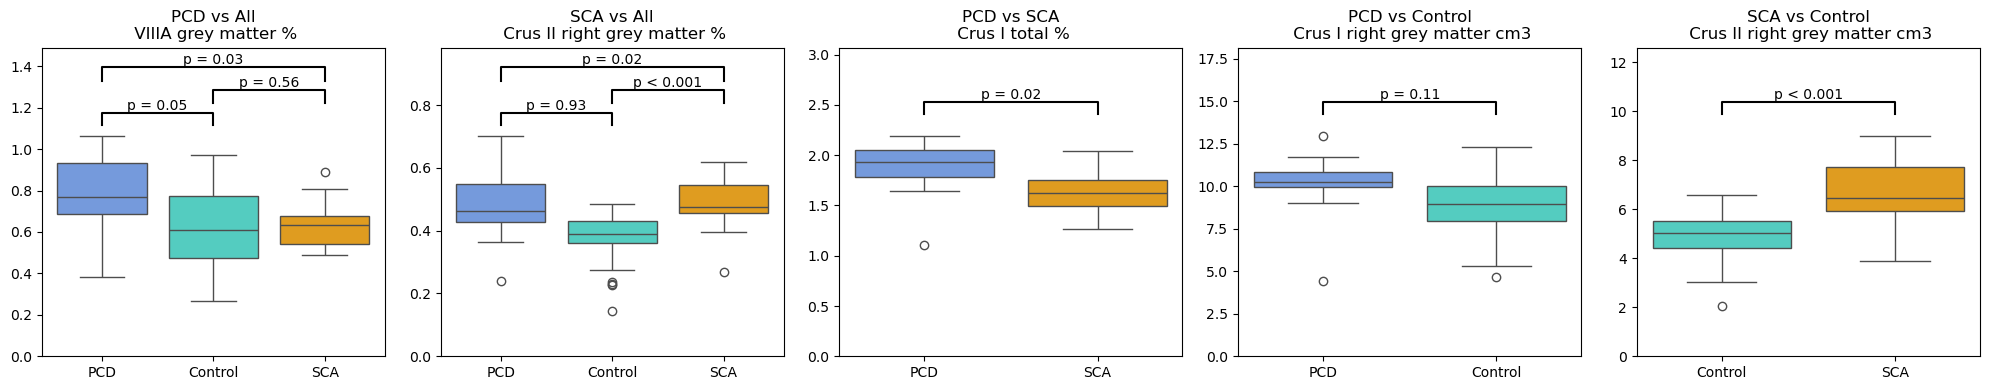

In [4]:
# Create figure and subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3)

# Get the best features from our previous analysis
for name, cfg in tasks.items():
    # subset & basic pre-processing
    sub = df.loc[cfg['mask']].copy()
    y = (sub[target] == cfg['pos']).astype(int).values
    X = sub[num_cols]
    keep = ~X.isna().any(axis=1)
    X, y = X[keep], y[keep]
    
    # Find best feature
    feat_aucs = {c: [] for c in num_cols}
    for tr, te in cv.split(X, y):
        for c in num_cols:
            feat_aucs[c].append(roc_auc_score(y[te], X.iloc[te][c]))
    best_feat = max(feat_aucs, key=lambda k: np.mean(feat_aucs[k]))
    
    # Create boxplots
    if name == 'PCD_vs_all':
        create_boxplots(axes[0], df, best_feat, 
                       f'PCD vs All\n {best_feat}', 
                       groups=['PCD', 'SCA', 'Control'])
    elif name == 'SCA_vs_all':
        create_boxplots(axes[1], df, best_feat, 
                       f'SCA vs All\n {best_feat}', 
                       groups=['PCD', 'SCA', 'Control'])
    elif name == 'PCD_vs_SCA':
        create_boxplots(axes[2], df, best_feat, 
                       f'PCD vs SCA\n {best_feat}',     
                       groups=['PCD', 'SCA'])
    elif name == 'PCD_vs_Control':
        create_boxplots(axes[3], df, best_feat,
                       f'PCD vs Control\n {best_feat}',
                       groups=['PCD', 'Control'])
    elif name == 'SCA_vs_Control':
        create_boxplots(axes[4], df, best_feat,
                       f'SCA vs Control\n {best_feat}',
                       groups=['SCA', 'Control'])

plt.tight_layout()
# Save the figure
plt.savefig('../results/feature_distributions.png', dpi=300, format='png', bbox_inches='tight')
plt.show()